In [ ]:
# pip install pandas numpy xgboost scikit-learn matplotlib boto3 tqdm

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.utils import shuffle
from datetime import timedelta
from tqdm import tqdm
import random
import os
import boto3
import tempfile
import io

In [5]:


# Define S3 info
bucket = 'kehmisjan2025'

# Initialize boto3 client
s3 = boto3.client('s3')
buffer = io.BytesIO()
s3.download_fileobj(bucket, 'targets0515.parquet', buffer)
buffer.seek(0)  # Move to the start of the buffer
targets = pd.read_parquet(buffer)


In [ ]:
# print(iit_data.dtypes) 
# Ensure the 'NAD' column is converted to datetime
targets['nad'] = pd.to_datetime(targets['nad'], format='%Y-%m-%d')

In [8]:
# remove the last quarter of the year
# Define the date range to exclude
before = pd.Timestamp('2024-09-30')
after = pd.Timestamp('2023-01-01')

# Filter out records from Sept through Dec 2024
targets = targets[(targets['nad'] >= after) & (targets['nad'] <= before)]

In [10]:
# filter out where nad imputation flag is 1
targets = targets[targets['nad_imputation_flag'] == 0]

In [ ]:
targets = targets.drop(columns=[
    'key', 'visitdate', 'nad_imputation_flag', 'sitecode', 'pregnant_missing',
    'breastfeeding_missing', 'startartdate', 'month', 'dayofweek', 'timeatfacility',
    'code', 'county'])
print(targets.shape)

(8478527, 67)


In [22]:
# filter to emr in kenyamer and ecare   
targets = targets[targets['emr'].isin(['kenyaemr', 'ecare'])]
# Emr: KenyaEMR -> 1, else 0
targets['emr'] = (targets['emr'] == 'kenyaemr').astype('Int64') 
print(targets.shape)


(7906314, 67)


In [ ]:
# targets.info()
# convert whostage and adherence to integers
targets['whostage'] = targets['whostage'].astype('float').astype('Int64')
targets['adherence'] = targets['adherence'].astype('Int64')

whostage
1    4892682
2     559628
3     290873
4      35213
Name: count, dtype: Int64

In [ ]:
categorical_columns = targets.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)

['cascadestatus', 'visitby', 'tcareason', 'differentiatedcare', 'maritalstatus', 'educationlevel', 'occupation', 'bmi', 'most_recent_vl', 'kephlevel', 'facilitytypecategory', 'ownertype']


In [31]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
ohe.fit(targets[categorical_columns])

OneHotEncoder(drop='first', handle_unknown='ignore')

In [40]:
def encode_xgboost(df, start_date, end_date, return_df=False):
    # Filter the DataFrame based on the date range
    mask = (df['nad'] >= start_date) & (df['nad'] <= end_date)
    filtered_df = df.loc[mask].copy()

    # Drop the 'nad' column
    filtered_df.drop(columns=['nad'], inplace=True)

    # One-hot encode the categorical columns
    encoded_features = ohe.transform(filtered_df[categorical_columns]).toarray()
    encoded_feature_names = ohe.get_feature_names_out(categorical_columns)
    
    # Create a DataFrame with the encoded features
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=filtered_df.index)
    
    # Concatenate the encoded features with the original DataFrame
    final_df = pd.concat([filtered_df.drop(columns=categorical_columns), encoded_df], axis=1)

    # convert to xgb.Dmatrix
    xgb_df = xgb.DMatrix(
        data=final_df.drop(columns=["iit"]),
        label=final_df["iit"]
    )

    if return_df:
        # If return_df is True, return the DataFrame and the DMatrix
        return final_df, xgb_df
    else:
        # If return_df is False, just return the DMatrix
        return xgb_df


Create folds 

In [43]:
# Fold 1 (Jan - Sep 2023)
dtrain1 = encode_xgboost(targets, '2023-01-01', '2023-05-31')
dval1 = encode_xgboost(targets, '2023-06-01', '2023-06-30')
testnear_data1, dtestnear1 = encode_xgboost(targets, '2023-07-01', '2023-07-31', return_df=True)
test_data1, dtest1 = encode_xgboost(targets, '2023-07-01', '2023-09-30', return_df=True)

# Fold 2 (Apr - Dec 2023)
dtrain2 = encode_xgboost(targets, '2023-04-01', '2023-08-31')
dval2 = encode_xgboost(targets, '2023-09-01', '2023-09-30')
testnear_data2, dtestnear2 = encode_xgboost(targets, '2023-10-01', '2023-10-31', return_df=True)
test_data2, dtest2 = encode_xgboost(targets, '2023-10-01', '2023-12-31', return_df=True)

# Fold 3 (Jul 2023 - March 2024)
dtrain3 = encode_xgboost(targets, '2023-07-01', '2023-11-30')
dval3 = encode_xgboost(targets, '2023-12-01', '2023-12-31')
testnear_data3, dtestnear3 = encode_xgboost(targets, '2024-01-01', '2024-01-31', return_df=True)
test_data3, dtest3 = encode_xgboost(targets, '2024-01-01', '2024-03-31', return_df=True)

# Fold 4 (Sep 2023 - June 2024)
dtrain4 = encode_xgboost(targets, '2023-10-01', '2024-02-29')
dval4 = encode_xgboost(targets, '2024-03-01', '2024-03-31')
testnear_data4, dtestnear4 = encode_xgboost(targets, '2024-04-01', '2024-04-30', return_df=True)
test_data4, dtest4 = encode_xgboost(targets, '2024-04-01', '2024-06-30', return_df=True)

# Fold 5 (Jan 2024 - Sep 2024)
dtrain5 = encode_xgboost(targets, '2024-01-01', '2024-05-31')
dval5 = encode_xgboost(targets, '2024-06-01', '2024-06-30')
testnear_data5, dtestnear5 = encode_xgboost(targets, '2024-07-01', '2024-07-31', return_df=True)
test_data5, dtest5 = encode_xgboost(targets, '2024-07-01', '2024-09-30', return_df=True)


In [44]:
fold_list = {
    "fold1": [dtrain1, dval1, dtestnear1, dtest1, testnear_data1, test_data1],
    "fold2": [dtrain2, dval2, dtestnear2, dtest2, testnear_data2, test_data2],
    "fold3": [dtrain3, dval3, dtestnear3, dtest3, testnear_data3, test_data3],
    "fold4": [dtrain4, dval4, dtestnear4, dtest4, testnear_data4, test_data4],
    "fold5": [dtrain5, dval5, dtestnear5, dtest5, testnear_data5, test_data5]
}
del dtrain1, dval1, dtestnear1, dtest1, testnear_data1, test_data1
del dtrain2, dval2, dtestnear2, dtest2, testnear_data2, test_data2
del dtrain3, dval3, dtestnear3, dtest3, testnear_data3, test_data3
del dtrain4, dval4, dtestnear4, dtest4, testnear_data4, test_data4
del dtrain5, dval5, dtestnear5, dtest5, testnear_data5, test_data5

In [ ]:

from itertools import product
from sklearn.metrics import precision_recall_curve, average_precision_score

# Step 1: Create the grid
params_grid = list(product(
    [0.01, 0.05],                  # eta
    [6, 8, 10],               # max_depth
    [0.5, 0.8, 1],           # subsample
    [0.5, 0.8, 1],           # colsample_bytree
    [1, 10],                     # lambda
    [30]                  # scale_pos_weight
))

# Build DataFrame
grid_sparse = pd.DataFrame(params_grid, columns=[
    "eta", "max_depth", "subsample", "col_sample", "lambda_", "scale_pos_weight"
])
# Add empty columns for PR AUCs
for k in range(1, 6):
    grid_sparse[f"val_pr_auc_near_{k}"] = np.nan
    grid_sparse[f"val_pr_auc_{k}"] = np.nan



In [52]:
grid_sparse.shape

(324, 16)

In [ ]:


# Step 3: Train models for each grid row and each fold
for i in tqdm(range(len(grid_sparse)), desc="Grid Search"):

    row = grid_sparse.iloc[i]

    for k in tqdm(range(1, 6), desc=f"Fold {i+1}", leave=False):

        dtrain, dval, dtestnear, dtest, test_near, test_data = fold_list[f"fold{k}"]

        # set the seed for reproducibility
        random.seed(2231)
        np.random.seed(2231)

        params = {
            "eta": row["eta"],
            "max_depth": int(row["max_depth"]),
            "subsample": row["subsample"],
            "colsample_bytree": row["col_sample"],
            "lambda": row["lambda_"],
            "scale_pos_weight": row["scale_pos_weight"],
            "eval_metric": "aucpr",
            "objective": "binary:logistic"
        }

        xgb_model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=3000,
            evals=[(dtrain, "train"), (dval, "val")],
            early_stopping_rounds=100,
            verbose_eval=False
        )

        # Predict on dtestnear
        testnear_preds = xgb_model.predict(dtestnear)
        ap_near = average_precision_score(test_near["iit"], testnear_preds)
        grid_sparse.at[grid_sparse.index[i], f"val_pr_auc_near_{k}"] = ap_near

        # Predict on dtest
        test_preds = xgb_model.predict(dtest)
        ap = average_precision_score(test_data["iit"], test_preds)
        grid_sparse.at[grid_sparse.index[i], f"val_pr_auc_{k}"] = ap

    print(grid_sparse.iloc[i])

# Save the grid_sparse DataFrame to a CSV file
grid_sparse.to_csv("grid_sparse.csv", index=False)
# Upload the CSV file to S3
with open("grid_sparse.csv", "rb") as f:
    s3.upload_fileobj(f, bucket, 'xgb_grid_sparse_0520.csv')


In [27]:

params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.5,
    'colsample_bytree': 0.6,
    'lambda': 1,
    'scale_pos_weight': 10,
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
}

random.seed(42)
gb_model = xgb.train(
    params=params,
    dtrain=dtrain5,
    num_boost_round=3000,
    evals=[(dtrain5, 'train'), (dval5, 'eval')],
    early_stopping_rounds=100,
    verbose_eval=False
)

In [28]:
# Define AUC-PR function
def compute_aucpr(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)
# Predict on dtest
test_preds = gb_model.predict(dtest5)
ap = compute_aucpr(test_data5["iit"], test_preds)
ap

np.float64(0.13074314035159054)

In [29]:
# Get feature importance by 'gain' (you can also use 'weight', 'cover', etc.)
importance = gb_model.get_score(importance_type='gain')

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(20))  # Top 10 features



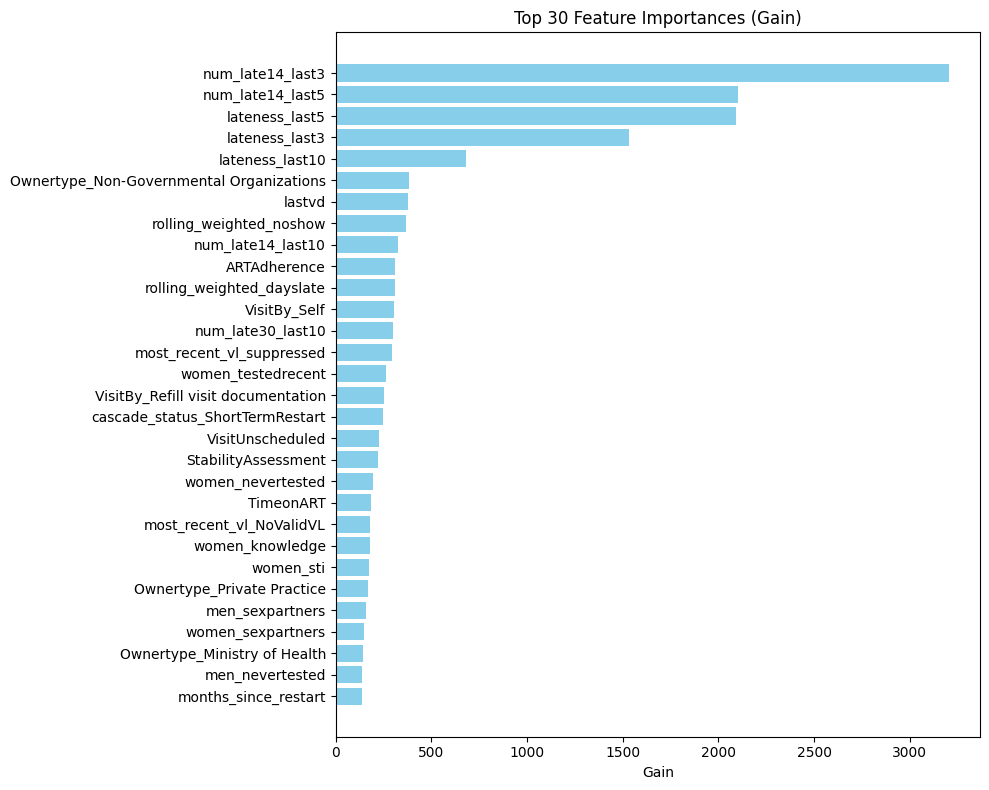

In [32]:
import matplotlib.pyplot as plt
# Select top 20
top_20 = importance_df.head(30)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_20['Feature'], top_20['Importance'], color='skyblue')
plt.xlabel('Gain')
plt.title('Top 30 Feature Importances (Gain)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [33]:
import shap
shap.initjs()
X_test=test_data5.drop(columns=["iit"])
y_test=test_data5["iit"]

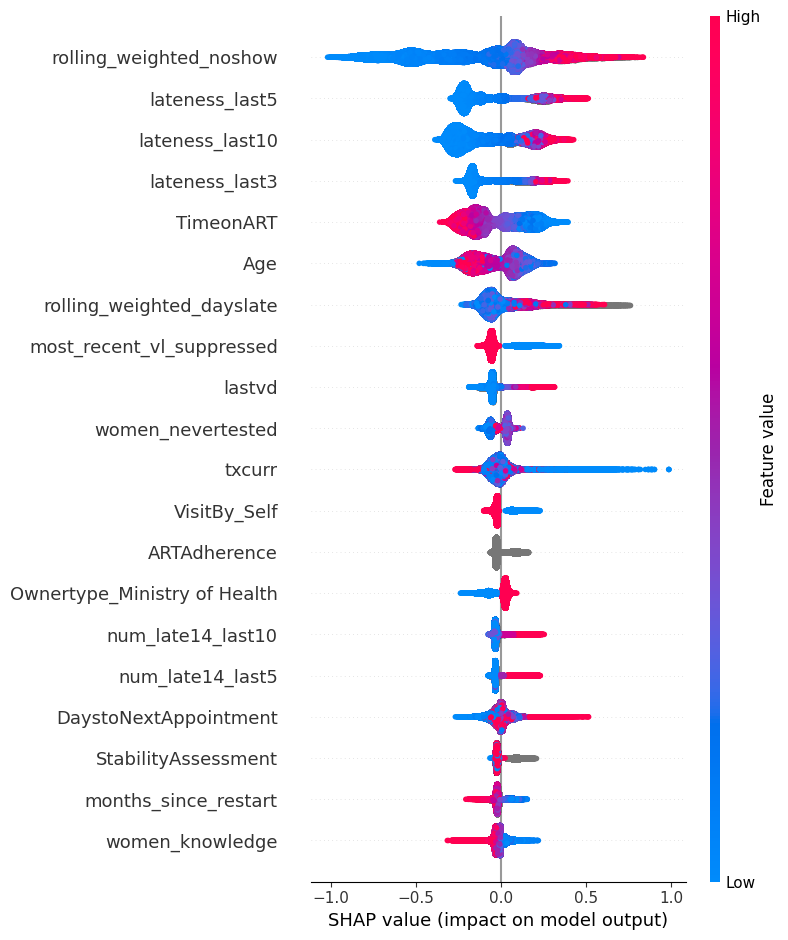

In [35]:

# Convert model to SHAP explainer
explainer = shap.TreeExplainer(gb_model)


# Compute SHAP values on test data (or any sample)
shap_values = explainer.shap_values(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test)


In [28]:
test = iit_data.copy()
test = test[(test["NAD"] >= "2024-07-01") & (test["NAD"] <= "2024-09-30")]
test["predictions_rf"]= test_preds

In [39]:
from io import StringIO
s3 = boto3.client('s3')  # assumes you've run aws configure or have IAM role
# Create a CSV in memory
csv_buffer = StringIO()
grid_sparse.to_csv(csv_buffer, index=False)
s3.put_object(
    Bucket='kehmisjan2025',
    Key='grid_sparse_xgb_041625.csv',
    Body=csv_buffer.getvalue()
)

{'ResponseMetadata': {'RequestId': 'K3TF4REVAR9B55WJ',
  'HostId': 'JeTHD3GFVsMse8kcFRrqyzl2qBLlFXxwKeTWUNYZ+9aaOOibCWVPxDonrwttF68kIlc9J4NwRSSWffHRdlO+ErobuBMcHdYo9ittPKkaBjI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'JeTHD3GFVsMse8kcFRrqyzl2qBLlFXxwKeTWUNYZ+9aaOOibCWVPxDonrwttF68kIlc9J4NwRSSWffHRdlO+ErobuBMcHdYo9ittPKkaBjI=',
   'x-amz-request-id': 'K3TF4REVAR9B55WJ',
   'date': 'Wed, 16 Apr 2025 09:46:47 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"8991655b27e6d43eff5eaf9db7547502"',
   'x-amz-checksum-crc32': 'P+gOxQ==',
   'x-amz-checksum-type': 'FULL_OBJECT',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"8991655b27e6d43eff5eaf9db7547502"',
 'ChecksumCRC32': 'P+gOxQ==',
 'ChecksumType': 'FULL_OBJECT',
 'ServerSideEncryption': 'AES256'}